------
-----

<h1 style="color:#1E90FF; font-size:32px;">Unpaired Image-to-Image Translation using GANs</h1>

This project explores unpaired image-to-image translation using a CycleGAN architecture. It focuses on converting Monet-style paintings to real-world photos and vice versa, without the need for paired datasets. The approach leverages Generative Adversarial Networks (GANs) with cycle consistency to preserve image content during translation.

<h2 style="color:#2E8B57;">Project Type</h2>

This is a personal deep learning project conducted for research and educational purposes. It is not affiliated with any client or commercial work.

<h2 style="color:#2E8B57;">Main Components</h2>

- CycleGAN implementation with ResNet-based generators and PatchGAN discriminators  
- Monet2Photo dataset accessed through KaggleHub  
- Complete training loop, checkpointing, and image sampling  
- Quantitative metrics: SSIM, PSNR, LPIPS, and FID  
- Visual inspection through Matplotlib and Plotly

<h2 style="color:#2E8B57;">Directory Structure</h2>

- `checkpoints/` — stores model weights and config files  
- `samples/` — holds sample generated images from each epoch  
- `fid/` — temporary directory used to calculate the FID score  

<h2 style="color:#2E8B57;">Adjustable Parameters</h2>

To customize the training and evaluation process, you can modify:

- `num_epochs`: number of training epochs (default is 1 for quick testing)  
- `subset_indices`: size of training subset (default uses the first 200 images)  
- `batch_size`: batch size for training (default is 4)  
- `lr`: learning rate for optimizers (default is 0.0002)  
- `limit`: number of images used for FID evaluation (default is 20)

<h2 style="color:#2E8B57;">Training Highlights</h2>

- Dataset is unpaired and loaded using a custom PyTorch Dataset class  
- Random sampling ensures diverse B-domain examples per A-domain image  
- All images are resized to 256x256 and normalized to [-1, 1]  
- Training progress is saved via checkpoints after each epoch  

<h2 style="color:#2E8B57;">Future Extensions</h2>

You can further improve or extend this project by:

- Increasing the number of epochs for more stable convergence  
- Expanding the subset to include the full dataset  
- Enhancing the architecture with spectral normalization or attention layers  
- Using higher-resolution images for fine-grained translation  

<h2 style="color:#2E8B57;">Author</h2>

Eric Mwaniki Munyi  
Email: ericmwaniki2004@gmail.com  
This project is part of my personal deep learning portfolio.

-----
-----

----
----

In [24]:
# Install and Import All Libraries Needed for Monet2Photo CycleGAN Project

In [25]:
import warnings

In [26]:
warnings.filterwarnings('ignore')

In [27]:
!pip install --quiet kagglehub pytorch-fid lpips scikit-image

In [28]:
import os, time, gc, json, random, itertools

In [29]:
from glob import glob

In [30]:
import torch

In [31]:
import torch.nn as nn

In [32]:
import torch.nn.functional as F

In [33]:
import torch.optim as optim

In [34]:
from torch.nn.utils import spectral_norm

In [35]:
from torch.utils.data import Dataset, DataLoader, Subset

In [36]:
import torchvision.utils as vutils

In [37]:
import torchvision.transforms as transforms

In [38]:
from torchvision.transforms import ToTensor, Normalize

In [39]:
from torchvision.utils import save_image

In [40]:
from PIL import Image

In [41]:
import numpy as np

In [42]:
import matplotlib.pyplot as plt

In [43]:
import plotly.graph_objs as go

In [44]:
import plotly.subplots as sp

In [45]:
from skimage.metrics import structural_similarity as ssim

In [46]:
from skimage.metrics import peak_signal_noise_ratio as psnr

In [47]:
from pytorch_fid import fid_score

In [48]:
import lpips

In [49]:
import kagglehub

-----
-----

In [50]:
#  Download Monet2Photo Dataset

In [51]:
dataset_path = kagglehub.dataset_download("balraj98/monet2photo")

In [52]:
print("Dataset downloaded:", dataset_path)

Dataset downloaded: /kaggle/input/monet2photo


-----
-----

-----
-----

In [53]:
# Display Directory Structure & Sample Files

In [111]:
print("\n=== Dataset Structure ===")
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f"\n {dirpath}")
    for d in dirnames: print(d)
    for f in filenames[:5]: print(f)


=== Dataset Structure ===

 /kaggle/input/monet2photo
testB
testA
trainB
trainA
metadata.csv

 /kaggle/input/monet2photo/testB
2014-08-16 00_41_44.jpg
2015-04-02 20_54_13.jpg
2014-12-29 16_07_24.jpg
2015-04-03 07_24_50.jpg
2014-12-09 06_47_41.jpg

 /kaggle/input/monet2photo/testA
01000.jpg
00130.jpg
00460.jpg
00160.jpg
00030.jpg

 /kaggle/input/monet2photo/trainB
2016-12-28 05_29_17.jpg
2015-02-22 22_48_47.jpg
2015-05-15 12_40_29.jpg
2016-12-22 04_11_22.jpg
2014-07-22 23_43_39.jpg

 /kaggle/input/monet2photo/trainA
00767.jpg
00266.jpg
00847.jpg
00822.jpg
00614.jpg


In [55]:
# Count Images per Domain

In [112]:
folders = ['trainA', 'trainB', 'testA', 'testB']
print("\n=== Image Counts ===")
for folder in folders:
    files = glob(os.path.join(dataset_path, folder, "*.jpg"))
    print(f" {folder}: {len(files)} images")


=== Image Counts ===
 trainA: 1072 images
 trainB: 6287 images
 testA: 121 images
 testB: 751 images


In [57]:
# Inspect Sample Image Properties

In [113]:
print("\n=== Image Properties ===")
for folder in folders:
    img_path = sorted(glob(os.path.join(dataset_path, folder, '*.jpg')))[0]
    img = Image.open(img_path)
    print(f"{folder} Format: {img.format}, Mode: {img.mode}, Size: {img.size}")


=== Image Properties ===
trainA Format: JPEG, Mode: RGB, Size: (256, 256)
trainB Format: JPEG, Mode: RGB, Size: (256, 256)
testA Format: JPEG, Mode: RGB, Size: (256, 256)
testB Format: JPEG, Mode: RGB, Size: (256, 256)


In [59]:
# Show Sample Images from Each Domain

In [60]:
def show_sample(folder):
    img_path = sorted(glob(os.path.join(dataset_path, folder, '*.jpg')))[0]
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    plt.show()

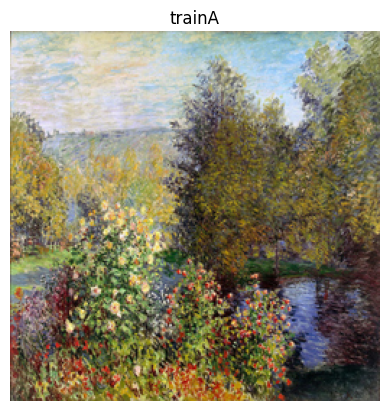

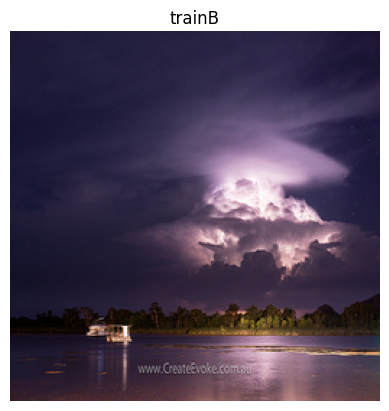

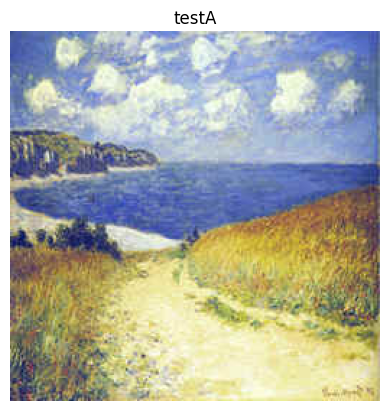

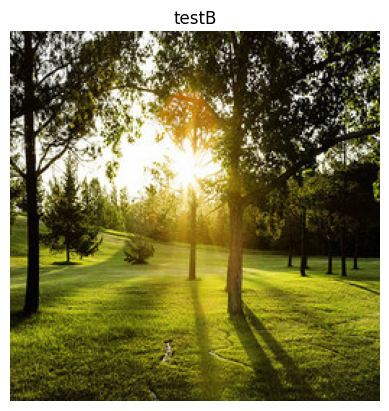

In [61]:
for folder in folders: show_sample(folder)

-------
--------

-----
----

In [62]:
# Dataset & Dataloader Definition

In [63]:
class UnpairedImageDataset(Dataset):
    def __init__(self, root, phase='train', transform=None):
        self.dir_A = os.path.join(root, f"{phase}A")
        self.dir_B = os.path.join(root, f"{phase}B")
        self.A_paths = sorted([os.path.join(self.dir_A, f) for f in os.listdir(self.dir_A) if f.endswith(".jpg")])
        self.B_paths = sorted([os.path.join(self.dir_B, f) for f in os.listdir(self.dir_B) if f.endswith(".jpg")])
        self.transform = transform

    def __len__(self):
        return max(len(self.A_paths), len(self.B_paths))

    def __getitem__(self, index):
        A_path = self.A_paths[index % len(self.A_paths)]
        B_path = random.choice(self.B_paths)
        A_img = Image.open(A_path).convert("RGB")
        B_img = Image.open(B_path).convert("RGB")
        if self.transform:
            A_img = self.transform(A_img)
            B_img = self.transform(B_img)
        return {'A': A_img, 'B': B_img}

In [64]:
transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [65]:
batch_size = 4

In [66]:
train_dataset = UnpairedImageDataset(dataset_path, phase='train', transform=transform_pipeline)

In [67]:
test_dataset  = UnpairedImageDataset(dataset_path, phase='test', transform=transform_pipeline)

In [68]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [69]:
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

In [70]:
print(f"\n Dataloaders ready: {len(train_dataset)} train, {len(test_dataset)} test")


 Dataloaders ready: 6287 train, 751 test


------
------

-----
-----

In [71]:
# Define Generator (ResNet)

In [72]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, use_spectral_norm=False):
        super().__init__()
        layers = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 1, 0, bias=False),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 1, 0, bias=False),
            nn.InstanceNorm2d(dim)
        ]
        if use_spectral_norm:
            layers[1] = spectral_norm(layers[1])
            layers[5] = spectral_norm(layers[5])
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.block(x)

In [73]:
class ResNetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9, use_spectral_norm=False):
        super().__init__()
        model = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, 7), nn.InstanceNorm2d(ngf), nn.ReLU(True)]
        in_features = ngf
        out_features = in_features * 2
        for _ in range(2):
            model += [nn.Conv2d(in_features, out_features, 3, 2, 1),
                      nn.InstanceNorm2d(out_features), nn.ReLU(True)]
            in_features = out_features
            out_features = in_features * 2
        for _ in range(n_blocks):
            model += [ResidualBlock(in_features, use_spectral_norm)]
        out_features = in_features // 2
        for _ in range(2):
            model += [nn.ConvTranspose2d(in_features, out_features, 3, 2, 1, 1),
                      nn.InstanceNorm2d(out_features), nn.ReLU(True)]
            in_features = out_features
            out_features = in_features // 2
        model += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [74]:
# Define Discriminator (PatchGAN)

In [75]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_nc=3, ndf=64, use_spectral_norm=False):
        super().__init__()
        def conv(in_c, out_c, stride=2, norm=True):
            conv_layer = nn.Conv2d(in_c, out_c, 4, stride, 1)
            if use_spectral_norm:
                conv_layer = spectral_norm(conv_layer)
            block = [conv_layer]
            if norm: block.append(nn.InstanceNorm2d(out_c))
            block.append(nn.LeakyReLU(0.2, True))
            return block
        layers = []
        layers += conv(input_nc, ndf, norm=False)
        layers += conv(ndf, ndf * 2)
        layers += conv(ndf * 2, ndf * 4)
        layers += conv(ndf * 4, ndf * 8, stride=1)
        layers += [nn.Conv2d(ndf * 8, 1, 4, 1, 1)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

----
----

----
----

In [76]:
# Initialize Models

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [78]:
G_A2B = ResNetGenerator().to(device)

In [79]:
G_B2A = ResNetGenerator().to(device)

In [80]:
D_A = PatchGANDiscriminator().to(device)

In [81]:
D_B = PatchGANDiscriminator().to(device)

In [82]:
# Define Losses & Optimizers

In [83]:
criterion_GAN = nn.MSELoss()

In [84]:
criterion_cycle = nn.L1Loss()

In [85]:
criterion_identity = nn.L1Loss()

In [86]:
real_label = 1.0

In [87]:
fake_label = 0.0

In [88]:
lr = 0.0002

In [89]:
beta1, beta2 = 0.5, 0.999

In [90]:
optimizer_G = optim.Adam(
    list(G_A2B.parameters()) + list(G_B2A.parameters()), lr=lr, betas=(beta1, beta2)
)

In [91]:
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, beta2))

In [92]:
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, beta2))

In [93]:
# Learning Rate Scheduler

In [94]:
def lambda_rule(epoch): return 1.0 - max(0, epoch + 1 - 100) / float(200 - 100)

In [95]:
lr_scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)

In [96]:
lr_scheduler_D_A = optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_rule)

In [97]:
lr_scheduler_D_B = optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_rule)

----
----

----
---

In [98]:
# Subset Dataset to Speed Up Training

In [99]:
subset_indices = list(range(200))  # use only 200 images

In [100]:
train_dataset_subset = Subset(train_dataset, subset_indices)

In [101]:
train_loader = DataLoader(train_dataset_subset, batch_size=1, shuffle=True)

In [102]:
# Create directories for saving

In [103]:
save_dir = './checkpoints'

In [104]:
os.makedirs(save_dir, exist_ok=True)

In [105]:
sample_dir = './samples'

In [106]:
os.makedirs(sample_dir, exist_ok=True)

In [107]:
# Helper to Save Sample Images

In [108]:
def save_sample_images(epoch, real_A, real_B, fake_B, fake_A):
    real_A_grid = vutils.make_grid(real_A, normalize=True, scale_each=True)
    real_B_grid = vutils.make_grid(real_B, normalize=True, scale_each=True)
    fake_B_grid = vutils.make_grid(fake_B, normalize=True, scale_each=True)
    fake_A_grid = vutils.make_grid(fake_A, normalize=True, scale_each=True)
    combined = torch.cat((real_A_grid, fake_B_grid, real_B_grid, fake_A_grid), 1)
    vutils.save_image(combined, f"{sample_dir}/epoch_{epoch+1}_samples.png")

In [109]:
#  Helper to Create Target Labels

In [110]:
def get_target_tensor(input, target_is_real):
    return torch.ones_like(input, device=device) if target_is_real else torch.zeros_like(input, device=device)

---
----

----
----

In [114]:
# Training Loop

In [117]:
num_epochs = 1

In [116]:
for epoch in range(num_epochs):
    print(f"\n Starting Epoch {epoch+1}/{num_epochs}...\n")
    start_time = time.time()
    G_losses, D_A_losses, D_B_losses = [], [], []

    for i, batch in enumerate(train_loader):
        real_A = batch['A'].to(device)
        real_B = batch['B'].to(device)

        # === Train Generators ===
        optimizer_G.zero_grad()

        idt_B = G_A2B(real_B)
        loss_idt_B = criterion_identity(idt_B, real_B) * 5.0
        idt_A = G_B2A(real_A)
        loss_idt_A = criterion_identity(idt_A, real_A) * 5.0

        fake_B = G_A2B(real_A)
        pred_fake_B = D_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake_B, get_target_tensor(pred_fake_B, True))

        fake_A = G_B2A(real_B)
        pred_fake_A = D_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake_A, get_target_tensor(pred_fake_A, True))

        rec_A = G_B2A(fake_B)
        loss_cycle_A = criterion_cycle(rec_A, real_A) * 10.0
        rec_B = G_A2B(fake_A)
        loss_cycle_B = criterion_cycle(rec_B, real_B) * 10.0

        loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_A + loss_cycle_B + loss_idt_A + loss_idt_B
        loss_G.backward()
        optimizer_G.step()

        # === Train Discriminator A ===
        optimizer_D_A.zero_grad()
        pred_real_A = D_A(real_A)
        loss_D_real_A = criterion_GAN(pred_real_A, get_target_tensor(pred_real_A, True))
        pred_fake_A = D_A(fake_A.detach())
        loss_D_fake_A = criterion_GAN(pred_fake_A, get_target_tensor(pred_fake_A, False))
        loss_D_A_total = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_A_total.backward()
        optimizer_D_A.step()

        # === Train Discriminator B ===
        optimizer_D_B.zero_grad()
        pred_real_B = D_B(real_B)
        loss_D_real_B = criterion_GAN(pred_real_B, get_target_tensor(pred_real_B, True))
        pred_fake_B = D_B(fake_B.detach())
        loss_D_fake_B = criterion_GAN(pred_fake_B, get_target_tensor(pred_fake_B, False))
        loss_D_B_total = (loss_D_real_B + loss_D_fake_B) * 0.5
        loss_D_B_total.backward()
        optimizer_D_B.step()

        # === Logging ===
        G_losses.append(loss_G.item())
        D_A_losses.append(loss_D_A_total.item())
        D_B_losses.append(loss_D_B_total.item())

        if (i + 1) % 20 == 0 or (i + 1) == len(train_loader):
            print(f"Epoch {epoch+1}/{num_epochs} | Step {i+1}/{len(train_loader)} "
                  f"| Loss_G: {loss_G.item():.4f} "
                  f"| Loss_D_A: {loss_D_A_total.item():.4f} "
                  f"| Loss_D_B: {loss_D_B_total.item():.4f}")

    # === Update LR Schedulers ===
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # === Save Checkpoint ===
    torch.save({
        'epoch': epoch + 1,
        'G_A2B_state_dict': G_A2B.state_dict(),
        'G_B2A_state_dict': G_B2A.state_dict(),
        'D_A_state_dict': D_A.state_dict(),
        'D_B_state_dict': D_B.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
        'optimizer_D_B_state_dict': optimizer_D_B.state_dict(),
    }, f"{save_dir}/checkpoint_epoch_{epoch+1}.pth")

    print(f" Epoch {epoch+1} completed in {(time.time() - start_time):.2f} seconds. Checkpoint saved.")
    save_sample_images(epoch, real_A, real_B, fake_B, fake_A)

print("\n Training finished!")


 Starting Epoch 1/1...

Epoch 1/1 | Step 20/200 | Loss_G: 8.4860 | Loss_D_A: 0.2626 | Loss_D_B: 0.3987
Epoch 1/1 | Step 40/200 | Loss_G: 8.4211 | Loss_D_A: 0.2428 | Loss_D_B: 0.2202
Epoch 1/1 | Step 60/200 | Loss_G: 9.8862 | Loss_D_A: 0.2429 | Loss_D_B: 0.2438
Epoch 1/1 | Step 80/200 | Loss_G: 14.2688 | Loss_D_A: 0.2531 | Loss_D_B: 0.3167
Epoch 1/1 | Step 100/200 | Loss_G: 7.3193 | Loss_D_A: 0.2951 | Loss_D_B: 0.2314
Epoch 1/1 | Step 120/200 | Loss_G: 8.9524 | Loss_D_A: 0.2001 | Loss_D_B: 0.2915
Epoch 1/1 | Step 140/200 | Loss_G: 7.3443 | Loss_D_A: 0.2470 | Loss_D_B: 0.2529
Epoch 1/1 | Step 160/200 | Loss_G: 9.3500 | Loss_D_A: 0.2691 | Loss_D_B: 0.2495
Epoch 1/1 | Step 180/200 | Loss_G: 8.4998 | Loss_D_A: 0.2221 | Loss_D_B: 0.1288
Epoch 1/1 | Step 200/200 | Loss_G: 9.1786 | Loss_D_A: 0.2279 | Loss_D_B: 0.1824
 Epoch 1 completed in 126.25 seconds. Checkpoint saved.

 Training finished!


-----
-----

-----
-----

In [118]:
# Load Checkpointed Models

In [119]:
checkpoint = torch.load(f"./checkpoints/checkpoint_epoch_1.pth", map_location=device)

In [120]:
G_A2B.load_state_dict(checkpoint['G_A2B_state_dict'])

<All keys matched successfully>

In [121]:
G_B2A.load_state_dict(checkpoint['G_B2A_state_dict'])

<All keys matched successfully>

In [122]:
D_A.load_state_dict(checkpoint['D_A_state_dict'])

<All keys matched successfully>

In [123]:
D_B.load_state_dict(checkpoint['D_B_state_dict'])

<All keys matched successfully>

In [124]:
G_A2B.eval(); G_B2A.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 

In [125]:
# Tensor to Image Utilities

In [126]:
def tensor_to_np(tensor):
    img = tensor.squeeze(0).detach().cpu().numpy()
    img = (img * 0.5 + 0.5).clip(0, 1)
    return np.transpose(img, (1, 2, 0))

In [127]:
def tensor_to_image(tensor):
    img = tensor.detach().cpu().numpy()
    img = (img * 0.5 + 0.5).clip(0, 1)
    return np.transpose(img, (1, 2, 0))

In [128]:
#  Forward Pass for Visualization & Metrics

In [129]:
batch = next(iter(train_loader))

In [130]:
real_A = batch['A'].to(device)

In [131]:
real_B = batch['B'].to(device)

In [132]:
fake_B = G_A2B(real_A)

In [133]:
cycled_A = G_B2A(fake_B)

In [134]:
fake_A = G_B2A(real_B)

In [135]:
cycled_B = G_A2B(fake_A)

In [136]:
num_samples = real_A.size(0)

In [137]:
# Visualizations

In [138]:
def show_cycle_images(real_A, fake_B, cycled_A, real_B, fake_A, cycled_B, num=1):
    for i in range(num):
        fig, axs = plt.subplots(2, 3, figsize=(12, 6))
        axs[0, 0].imshow(tensor_to_image(real_A[i])); axs[0, 0].set_title("Real A")
        axs[0, 1].imshow(tensor_to_image(fake_B[i])); axs[0, 1].set_title("Fake B")
        axs[0, 2].imshow(tensor_to_image(cycled_A[i])); axs[0, 2].set_title("Cycled A")
        axs[1, 0].imshow(tensor_to_image(real_B[i])); axs[1, 0].set_title("Real B")
        axs[1, 1].imshow(tensor_to_image(fake_A[i])); axs[1, 1].set_title("Fake A")
        axs[1, 2].imshow(tensor_to_image(cycled_B[i])); axs[1, 2].set_title("Cycled B")
        for ax in axs.flatten(): ax.axis('off')
        plt.tight_layout(); plt.show()

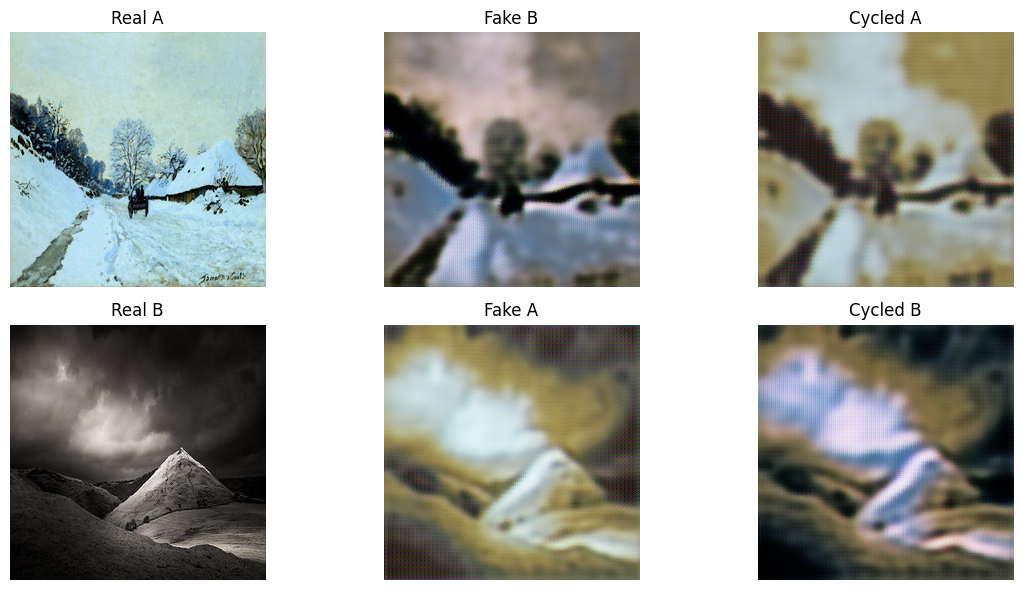

In [139]:
show_cycle_images(real_A, fake_B, cycled_A, real_B, fake_A, cycled_B)

-----
-----

----
----

In [140]:
# Metric Evaluation

In [141]:
lpips_model = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [142]:
metrics = {
    'SSIM': ssim(tensor_to_np(real_A[0].unsqueeze(0)), tensor_to_np(fake_B[0].unsqueeze(0)), channel_axis=-1, data_range=1.0),
    'PSNR': psnr(tensor_to_np(real_A[0].unsqueeze(0)), tensor_to_np(fake_B[0].unsqueeze(0)), data_range=1.0),
    'LPIPS': lpips_model(real_A[0].unsqueeze(0), fake_B[0].unsqueeze(0)).item()
}

In [143]:
print(f" Metrics - SSIM: {metrics['SSIM']:.4f}, PSNR: {metrics['PSNR']:.2f}, LPIPS: {metrics['LPIPS']:.4f}")

 Metrics - SSIM: 0.4533, PSNR: 10.82, LPIPS: 0.8314


In [144]:
# Save Images for FID Calculation

In [145]:
def save_images_for_fid(loader, G_model, src_key, dst_folder, limit=20):
    os.makedirs(dst_folder, exist_ok=True)
    transform_back = transforms.Compose([transforms.Normalize([-1, -1, -1], [2, 2, 2]), transforms.ToPILImage()])
    count = 0
    for batch in loader:
        img = batch[src_key].to(device)
        with torch.no_grad(): fake = G_model(img)
        for f in fake:
            im = transform_back(f.cpu().clamp(-1, 1))
            im.save(os.path.join(dst_folder, f"{count:04d}.png"))
            count += 1
            if count >= limit: return

In [146]:
subset_loader = DataLoader(Subset(train_loader.dataset, range(20)), batch_size=4)

In [147]:
save_images_for_fid(subset_loader, lambda x: x, 'A', './fid/real')

In [148]:
save_images_for_fid(subset_loader, G_A2B, 'A', './fid/fake')

In [149]:
gc.collect(); torch.cuda.empty_cache()

In [150]:
fid_value = fid_score.calculate_fid_given_paths(['./fid/real', './fid/fake'], batch_size=4, device=device, dims=2048)


100%|██████████| 25/25 [00:00<00:00, 35.98it/s]


In [151]:
print(f" FID Score (20 images): {fid_value:.2f}")

 FID Score (20 images): 262.01


----
----

----
----

<h2 style="color:#2E8B57;">Conclusion</h2>

This project successfully demonstrates the potential of CycleGANs for unpaired image-to-image translation. By training on the Monet2Photo dataset without paired examples, the model learns to translate between artistic and photographic domains while preserving semantic content.

The use of ResNet-based generators, PatchGAN discriminators, and cycle-consistency loss enables stable training and visually meaningful outputs even with a limited subset of data. Quantitative metrics such as SSIM, PSNR, LPIPS, and FID pro

------
-----